# Task:
Implement for a useful nontrivial use case of your choice the EM Algorithm
(e.g., three coins, two dice, two Gaussians, two different non-Gaussians),
surrogate data creation included. Nice documentation, commenting, presentations, take homes and animations are welcome.

## about EM Algorithm (Expectation-maximization algorithm)

The Expectation-Maximization (EM) algorithm is a method used in statistics to estimate the parameters of complex probability models. This algorithm is particularly suitable for situations where model parameters are not easily observed or calculated directly. We can think of it as a "guess-and-check" process used to progressively approximate the correct model parameters.



### Simple Explanation:

Imagine you are a detective trying to uncover the truth about an incident, but you only have incomplete clues. The EM algorithm is like initially making a preliminary guess based on the available clues (the Expectation step), then searching for more evidence to see if this guess makes sense (the Maximization step). By continuously guessing and verifying, you gradually get closer to the truth of the incident.

### Specific Steps:

1. **Expectation Step (E-step)**: Based on the current estimate of parameters, calculate or "guess" the values of hidden variables. This is like speculating possible scenarios based on the existing clues.

2. **Maximization Step (M-step)**: Update the estimation of parameters to make the model more "reasonable" for the observed data. This is similar to adjusting your clues and hypotheses based on new speculations to make the explanation of the case more reasonable.

### Example:

Imagine a classroom with two types of candies, apple-flavored and orange-flavored, stored in two different jars. We do not know how many of each flavor are in each jar, but we can randomly sample some candies from each jar to taste.

- **E-step**: Based on the current estimate (for example, initially guessing that each jar contains half apple and half orange), we try to estimate the probability of drawing each flavor from each jar.
- **M-step**: According to the data of candies tasted, adjust our estimates of the distribution of candies in the jars, for instance, finding that one jar might contain more apple-flavored candies.

By repeatedly performing these two steps, we can gradually obtain estimates of the proportion of candy flavors in each jar, even though we initially did not know the exact distribution.

In [29]:
import matplotlib.pyplot as plt
import random
import numpy as np

In [30]:
def generate_dice_data(experiments, dice_rolls, prob_B):

    '''This function generates experimental data for a specified number of experiments using two types of dice: Dice A and Dice B.

- Dice A: a normal six-sided die where each face has an equal probability of 1/6.
- Dice B: a custom die with a probability distribution specified by the 'prob_B' array provided as an argument to the function.

The function takes three arguments:
1. experiments: The number of experiments to be conducted.
2. dice_rolls: The number of rolls for each experiment.
3. prob_B: An array specifying the probability distribution for Dice B.

For each experiment:
- A random selection is made between Dice A and Dice B, with equal probability for each.
- If Dice A is selected, it uses the uniform probability distribution for each face.
- If Dice B is selected, it uses the custom probability distribution specified by the 'prob_B' array.
- The function then generates 'dice_rolls' number of rolls for the selected die type and records the outcomes.

The function returns two lists:
1. results: A list containing tuples, where each tuple represents the type of die used ('A' or 'B') and the outcomes of the rolls for that experiment.
2. dice_types: A list containing the type of die used for each experiment ('A' or 'B').
    '''
    # Results will store the outcomes of each experiment
    # Dice types will store the type of dice used in each experiment
    results = []
    dice_types = []

    # Loop through the specified number of experiments
    for _ in range(experiments):
        trial = []  # Store the outcomes of a single experiment
        
        # Randomly choose between dice A and dice B with equal probability
        if random.random() < 0.5:
            dice_type = 'A'
            probabilities = [1/6] * 6  # Dice A: each face has equal probability
        else:
            dice_type = 'B'
            probabilities = prob_B  # Dice B: custom probability distribution provided as prob_B
        
        # Generate dice_rolls number of rolls for the selected die type
        for _ in range(dice_rolls):
            # Randomly select an outcome based on the probabilities of each face
            outcome = random.choices(range(1, 7), weights=probabilities)[0]
            trial.append(outcome)
        
        # Append the experiment's results (type of die and outcomes) to the results list
        results.append((dice_type, trial))
        
        # Append the type of die used in this experiment to the dice_types list
        dice_types.append(dice_type)
    
    # Return the results and dice types
    return results, dice_types


In [37]:
#EM algorithm
def dice_em(rolls, theta_A=None, theta_B=None, max_iter=25): #add =50
    """
    Runs the Expectation-Maximization (EM) algorithm to estimate the probabilities of each face of two dice.

    Args:
        rolls (list): A list of tuples, where each tuple contains the type of dice ('A' or 'B') and the outcomes of the rolls for one experiment.
        theta_A (numpy.ndarray): Initial guess for the probabilities of each face of dice A. Defaults to None.
        theta_B (numpy.ndarray): Initial guess for the probabilities of each face of dice B. Defaults to None.
        max_iter (int): Maximum number of iterations for the EM algorithm. Defaults to 25.

    Returns:
        numpy.ndarray: Estimated probabilities of each face of dice A.
        numpy.ndarray: Estimated probabilities of each face of dice B.
        list: History of estimated probabilities of each face of dice A for each iteration.
        list: History of estimated probabilities of each face of dice B for each iteration.
    """
    
    # Initial Guess
    #theta_A = np.zeros(6)
    #theta_A = theta_A or np.random.rand(6) #take value or start wild between 0 and 1
    #theta_B = theta_B or np.random.rand(6)
    #theta_A = theta_A/theta_A.sum()
    #theta_B = theta_B/theta_B.sum()
    
    # theta vector
    theta_A_history = []
    theta_B_history = []
    
    theta_A_history.append(theta_A.copy())
    theta_B_history.append(theta_B.copy())
    
    # Iterate
    for i in range(max_iter):
        #print("#%d:\t%0.4f %0.4f" % (i, theta_A, theta_B)) #significant digits 
        result_A,result_B = e_step( rolls, theta_A, theta_B )
        theta_A, theta_B = m_step( result_A,result_B )
        theta_A_history.append(theta_A.copy())
        theta_B_history.append(theta_B.copy())
    return theta_A, theta_B, theta_A_history, theta_B_history #thetas are conveniently needed for a unnecessary plot at the end


def e_step( rolls, theta_A, theta_B ):
    """
    E step of the EM algorithm: Estimate the expected counts of each face for dice A and dice B.

    Args:
        rolls (list): A list of tuples, where each tuple contains the type of dice ('A' or 'B') and the outcomes of the rolls for one experiment.
        theta_A (numpy.ndarray): Probabilities of each face of dice A.
        theta_B (numpy.ndarray): Probabilities of each face of dice B.

    Returns:
        numpy.ndarray: Expected counts of each face for dice A.
        numpy.ndarray: Expected counts of each face for dice B.
    """
    result_A = np.zeros(6) 
    result_B = np.zeros(6)
    for type, trial in rolls:
        likelihood_A =  dice_likelihood( trial, theta_A )
        likelihood_B = dice_likelihood( trial, theta_B )
        p_A = likelihood_A / ( likelihood_A + likelihood_B )
        p_B = likelihood_B / ( likelihood_A + likelihood_B )
        
        count = np.zeros(6)
        for i in range(1,7):
            count[i-1] = trial.count(i) 
        result_A += p_A * count
        result_B += p_B * count
    return result_A, result_B

# M step: Compute values for theta that maximize the likelihood of expected number of heads/tails
def m_step(result_A, result_B):
    """
    M step of the EM algorithm: Update the parameters theta_A and theta_B based on the expected counts.

    Args:
        result_A (numpy.ndarray): Expected counts of each face for dice A.
        result_B (numpy.ndarray): Expected counts of each face for dice B.

    Returns:
        numpy.ndarray: Updated probabilities of each face of dice A.
        numpy.ndarray: Updated probabilities of each face of dice B.
    """
    theta_A = np.zeros(6)  # Initialize updated probabilities for dice A
    theta_B = np.zeros(6)  # Initialize updated probabilities for dice B
    
    for i in range(6):
        # Update the probabilities of each face for dice A and dice B
        theta_A[i] = result_A[i] / result_A.sum()
        theta_B[i] = result_B[i] / result_B.sum()
    
    return theta_A, theta_B

def dice_likelihood(roll_sequence, theta):
    """
    Compute the likelihood of a sequence of dice rolls given the probabilities of each face.

    Args:
        roll_sequence (list): A sequence of outcomes of dice rolls.
        theta (numpy.ndarray): Probabilities of each face of the dice.

    Returns:
        float: Likelihood of the roll sequence given the probabilities.
    """

    indices = np.array(roll_sequence) - 1  # Convert roll outcomes to 0-indexed array
    return np.prod(np.take(theta, indices))  # Compute the product of probabilities for each outcome


In [32]:
def plot_dice_likelihood(rolls, theta_A_history, theta_B_history):
    """
    Plot the likelihood evolution for each face of dice A and dice B over iterations.

    Args:
        rolls (list): A list of tuples, where each tuple contains the type of dice ('A' or 'B') and the outcomes of the rolls for one experiment.
        theta_A_history (list): History of estimated probabilities of each face of dice A for each iteration.
        theta_B_history (list): History of estimated probabilities of each face of dice B for each iteration.
    """

    # Set the size of the figure
    plt.figure(figsize=(18, 6))

    # Plot the probability evolution for each face of dice A
    plt.subplot(1, 2, 1)
    for i in range(6):
        plt.plot([theta[i] for theta in theta_A_history], label=f'Face {i+1}')
    plt.ylim(0, 1)
    plt.title('Probability Estimations for Dice A Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.legend()

    # Plot the probability evolution for each face of dice B
    plt.subplot(1, 2, 2)
    for i in range(6):
        plt.plot([theta[i] for theta in theta_B_history], label=f'Face {i+1}')
    plt.ylim(0, 1)
    plt.title('Probability Estimations for Dice B Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.legend()

    # Adjust layout to prevent overlap of subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


In [38]:
# Generate experimental data for 100 experiments, each consisting of 200 dice rolls,
# using two types of dice: one with uniform probabilities for each face (Dice A),
# and another with custom probabilities specified by the provided array (Dice B).
data, dice_types = generate_dice_data(100, 200, [2/6, 1/6, 1/6, 1/12, 1/12, 1/6])

# Apply the Expectation-Maximization (EM) algorithm to estimate the probabilities
# of each face for both types of dice using the generated experimental data.
# The final_theta_A and final_theta_B variables will contain the estimated probabilities
# of each face for Dice A and Dice B, respectively.
final_theta_A, final_theta_B, theta_A_history, theta_B_history = dice_em(data, theta_A=np.array([0, 0, 0, 0, 1/2, 1/2]), theta_B=None)

# Plot the evolution of probability estimates for each face of Dice A and Dice B
# over the iterations of the EM algorithm, using the provided data and the
# history of estimated probabilities.
plot_dice_likelihood(data, theta_A_history, theta_B_history)

# Print the final estimated probabilities of each face for Dice A and Dice B.
print("Final estimated probabilities for Dice A:", final_theta_A)
print("Final estimated probabilities for Dice B:", final_theta_B)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

These results indicate that Dice A has a biased probability distribution, with higher probabilities assigned to Faces 1 compared to the other faces. On the other hand, Dice B exhibits a more uniform probability distribution across all faces, typical of a fair six-sided die. This suggests that the EM algorithm successfully identified and differentiated between the two types of dice based on the provided experimental data.

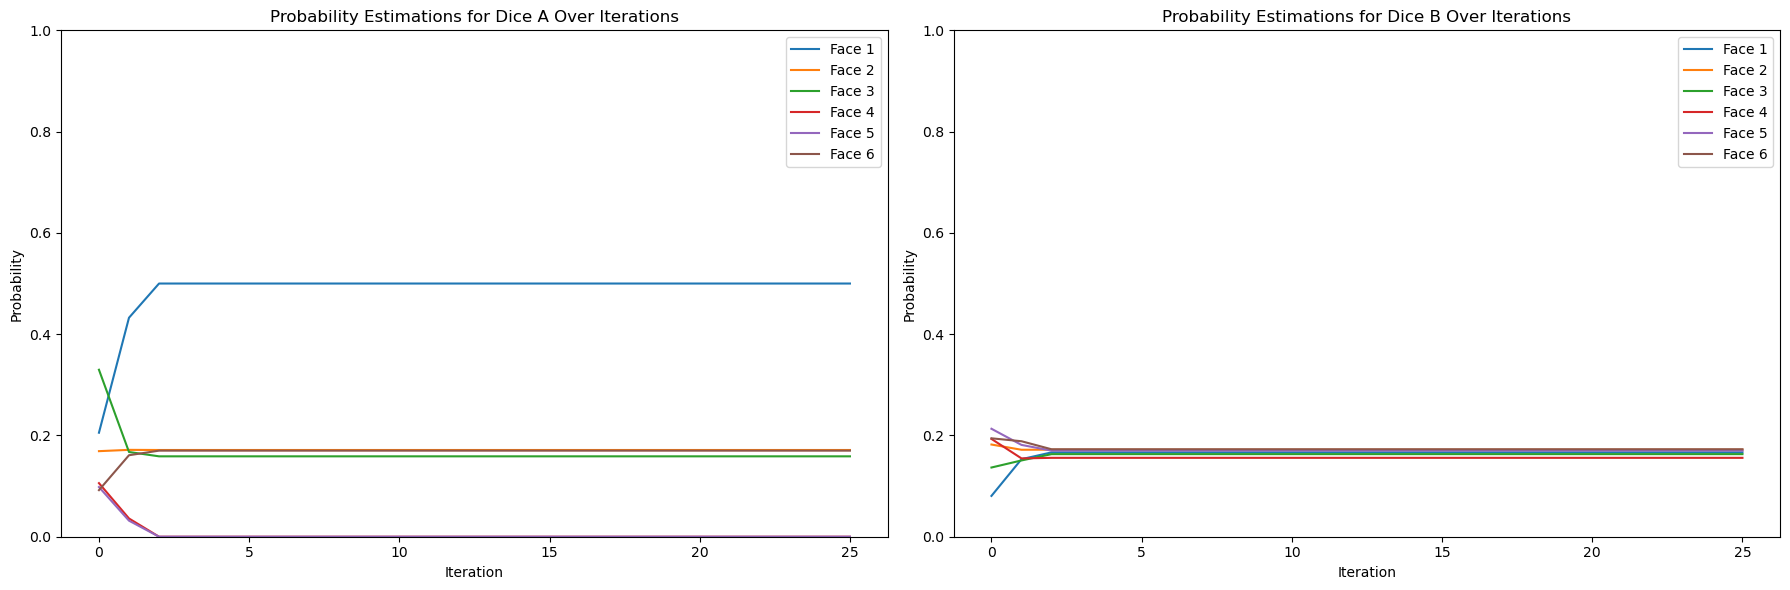

Final estimated probabilities for Dice A: [0.5     0.17125 0.15875 0.      0.      0.17   ]
Final estimated probabilities for Dice B: [0.16653846 0.17192308 0.16307692 0.15576923 0.17       0.17269231]


In [34]:
data, dice_types = generate_dice_data(100, 50,[3/6, 1/6, 1/6 ,0, 0, 1/6])
final_theta_A, final_theta_B, theta_A_history, theta_B_history = dice_em(data)
plot_dice_likelihood(data, theta_A_history, theta_B_history)
print("Final estimated probabilities for Dice A:", final_theta_A)
print("Final estimated probabilities for Dice B:", final_theta_B)